# SCENTInEL
#### sc ElasticNet transductive and inductive ensemble learning

# Bayes sampler and pseudocell creation module benchmarking

##### Ver:: A0_V2_2
##### Author(s) : Issac Goh
##### Date : 231002;YYMMDD
### Author notes

### Features to add

### Modes to run in


### Features added:
- Updated dynamic expansion and aggregation modules

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scentinel as scent
import pickle as pkl
import matplotlib.pyplot as plt


#¢ new modules
import psutil
import time
import threading
from scipy.interpolate import UnivariateSpline
from queue import Queue, Empty
import scipy

Make sure that Python modules winreg, win32api or win32con are installed.
INFO: blas_opt_info:
INFO: blas_armpl_info:
INFO: customize UnixCCompiler
INFO:   libraries armpl_lp64_mp not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: blas_mkl_info:
INFO:   libraries mkl_rt not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: blis_info:
INFO:   libraries blis not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: openblas_info:
INFO:   libraries openblas not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: accelerate_info:
INFO:   NOT AVAILABLE
I

# Using un-stratified sampling module
- This module provides different attention metrics for local/global node importance measures
- Uses the prior attention scores based on the established graph as priors
- Able to dybnamically up-sample under-represented states if "replace==True"
- Penalises highly dense regions as sufficient information is available to resonctruct all relationships
- preserves the neighborhood structure so relationship to original graph is retained

In [2]:
models = {
'pan_fetal_wget':'https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl',
'YS_wget':'https://storage.googleapis.com/haniffalab/yolk-sac/YS_X_A2_V12_lvl3_ELASTICNET_YS.sav',
}

adatas_dict = {
'pan_fetal_wget':'https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad',
'pan_fetal_local':'/nfs/team205/ig7/resources/github/pan_fetal_test.h5ad',
'YS_wget':'https://app.cellatlas.io/yolk-sac/dataset/23/download',
'YS_local':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw_obsm.h5ad',
'YS_pre_agm':'https://app.cellatlas.io/yolk-sac/dataset/10/download',
'FLIV_wget':'https://app.cellatlas.io/fetal-liver/dataset/1/download',
'int_atlas_sub':'/nfs/team298/ar32/Thesis_lab_hdca/label_testing_on_vae/scENTInEL/integrative_atlas_work/nib6k28e_50_raw_counts_with_graph.h5ad',
'A1_0_1_int_atlas_full':'/nfs/team298/ar32/Thesis_lab_hdca/from_kemal/14_dataset_with_leiden.h5ad',
'A1_0_2_int_atlas_full':  '//nfs/team298/ar32/Thesis_lab_hdca/label_testing_on_vae/scENTInEL/integrative_atlas_work/nib6k28e_50_raw_counts_with_graph.h5ad',
    
}

#setup global params:
# Variable assignment
train_model = True
adata_key = 'pan_fetal_local'#'int_atlas_full'#'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local 
data_merge = False # read and merge multiple adata (useful, but keep false for now)
model_key = 'new_example_model'#'pan_fetal_wget'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local 
#dyn_std = 1.96 # Dynamic cutoffs using std of the mean for each celltype probability, gives a column notifying user of uncertain labels 1 == 68Ci, 1.96 = 95CI
freq_redist = False# #'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters // not currently implemented
QC_normalise = False # should data be normalised?

# setup model parameters:
model_params = {
'feat_use': 'anno_lvl_2_final_clean',#'LVL3',#'anno_lvl_2_final_clean',
#'train_x_partition' : 'X_scvi', # what partition was the data trained on?
#'penalty':'elasticnet', # can be ["l1","l2","elasticnet"],
#'var_length' : 7500,
#'batch_key' : None,
#'sparcity' : 0.5, #If using LR without optimisation, this controls the sparsity in model C penalty for degree of regularisation
#'max_iter' : 1000, #Increase if experiencing max iter issues
#'thread_num' : -1,
#'l1_ratio' : 0.5, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
#'partial_scale' : False, # should data be scaled in batches?
#'tune_hyper_params' : True, # Current implementation is very expensive, intentionally made rigid for now
#'batch_correction' : False,
#'loss':'logloss',
#'sketch_tune':False, # warning, do not use this if you are already sub-sampling
    
# Stratified Bayes sampler kwargs
'sample_data_knn':True,
'straify_sampling':False, # Whether to stratify the sampling by "feat_use" or not
'knn_key' : 'scvi',#'scvi',
'sampling_rate': 0.05,# Apply empirical bayes sampling weighted by knn?
'weight_penalty': 'laplacian_SGD_pagerank', # Or 'entropy_distance' or "connectivity_ratio" or "laplacian" or "laplacian_SGD_pagerank"
'iterations': 10,#How many iterations of sampling to use for empirical bayes sampler? Probabilities update for each iteration and favour rare-states, increasing iter, naturally increases rare-sampling events
'representation_priority': 0.7, # This exponentially controls the sampling rate for rare-states, where 1 represents low-prioritisation, 0.1 represetns maximum prioritisation
'replace': False, # Allows model to clone cells
'equal_allocation': False, # Forces model to create equal representation sets
'resample_clones':True, # Reduce the number of clone cells where possible
'pl_label_entropy':False,
# 'tolerance':1e-7,
# 'initial_learning_rate':0.85,
    

# Params for SGD-pagerank
'num_iterations': 1000,# How many mini-batches to learn
'mini_batch_size': 10000,# How large should each mini-batch be
'full_batch_update_iters': 200, # How many full batch updates
'dynamic_hop' : True, # Perform dynamic hop operation?
'epoch' : 5, # This parameter controls the maxiumum number iterations prior to reconstruction
'alpha':0,  # This parameter controls the minimum number of hops to reach an anchor state -- this controls dynamic graph coverage
'n_jobs':4, # this paramter controls the number of parralel jobs to distribute the reconstruction of the connectivity matrix over
'adaptive_prune':True, # this parameter determines if adaptive pruning should be performed post dyanmic expansion
'force_symmetry':True,
}

# resource monitor

In [3]:
import os
import psutil
import time
from scipy.interpolate import UnivariateSpline
from queue import Queue, Empty

class ResourceMonitor:
    def __init__(self):
        self.control_queue = Queue()
        self.sys_memory_data = []
        self.vms_memory_data = []
        self.rss_memory_data = []
        self.cpu_data = []
        self.time_data = []
        self.thread = None

    def monitor_resources(self, interval=1):
        """Monitor system resources at intervals."""
        pid = os.getpid()
        current_process = psutil.Process(pid)
        while True:
            try:
                message = self.control_queue.get(timeout=interval)
                if message == "stop":
                    break
            except Empty:
                pass
            memory_usage = current_process.memory_info()
            self.sys_memory_data.append(psutil.virtual_memory().used / (1024 ** 2))
            self.rss_memory_data.append(memory_usage.rss / (1024 ** 2))
            self.vms_memory_data.append(memory_usage.rss / (1024 ** 2))
            self.cpu_data.append(psutil.cpu_percent(interval=None))
            self.time_data.append(time.time())

    def start_monitoring(self, interval=1):
        """Start the monitoring in a separate thread."""
        self.thread = threading.Thread(target=self.monitor_resources, args=(interval,))
        self.thread.start()

    def stop_monitoring(self):
        """Stop the monitoring."""
        self.control_queue.put("stop")
        if self.thread:
            self.thread.join()

def plot_resources(monitor,mem_key = 'rss_memory_data',cpu_key = 'cpu_data'):
    monitor.memory_data = getattr(monitor,mem_key)
    monitor.cpu_data = getattr(monitor,cpu_key)
    
    """Plot the collected resource data."""
    plt.figure(figsize=(12, 10))
    
    # Memory Usage Over Time
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(monitor.time_data, monitor.memory_data, '-o', color="blue", label="Memory Usage")
    ax1.fill_between(monitor.time_data, 0, monitor.memory_data, color="blue", alpha=0.3)
    ax1.set_ylim(min(monitor.memory_data) - 0.1 * min(monitor.memory_data), max(monitor.memory_data) + 0.1 * max(monitor.memory_data))
    
    # Add smoothed spline for memory data
    spl_memory = UnivariateSpline(monitor.time_data, monitor.memory_data, s=100)
    ax1.plot(monitor.time_data, spl_memory(monitor.time_data), 'k-', linewidth=2, label="Smoothed Memory Usage")
    
    ax1.set_title("{} Usage Over Time".format(mem_key))
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Memory (MB)")
    ax1.legend()
    
    # CPU Usage Over Time
    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(monitor.time_data, monitor.cpu_data, '-o', color="red", label="CPU Usage")
    ax2.fill_between(monitor.time_data, 0, monitor.cpu_data, color="red", alpha=0.3)
    ax2.set_ylim(min(monitor.cpu_data) - 5, max(monitor.cpu_data) + 5)  # giving a buffer of 5% for CPU
    # Add smoothed spline for CPU data
    spl_cpu = UnivariateSpline(monitor.time_data, monitor.cpu_data, s=10)
    ax2.plot(monitor.time_data, spl_cpu(monitor.time_data), 'k-', linewidth=2, label="Smoothed CPU Usage")
    
    ax2.set_title("{} Usage Over Time".format(cpu_key))
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("CPU (%)")
    ax2.legend()
    
    # Histogram for Memory Usage
    ax3 = plt.subplot(2, 2, 3)
    ax3.hist(monitor.memory_data, bins=30, color="blue", alpha=0.7)
    ax3.set_title("Histogram of {} Usage".format(mem_key))
    ax3.set_xlabel("Memory (MB)")
    ax3.set_ylabel("Frequency")
    
    # Histogram for CPU Usage
    ax4 = plt.subplot(2, 2, 4)
    ax4.hist(monitor.cpu_data, bins=30, color="red", alpha=0.7)
    ax4.set_title("Histogram of {} Usage".format(cpu_key))
    ax4.set_xlabel("CPU (%)")
    ax4.set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()


# Start resource monitoring

In [4]:
# Create an instance of the ResourceMonitor
monitor = scent.ResourceMonitor()
# Start monitoring
monitor.start_monitoring(interval=1)
import time
time.sleep(3)
# define a capture dictionary
cap_cnt = 0 

# A0.2.1 Update:
- For the unstratified sampling module, we should include graph summarisation metrics
- We should loop into epochs for each run of the SGDPR, carrying forward V_opt from previous epochs.
- Let's now consider only updating the local neighborhoods of selected vertices
- Theoretically increasing the neighborhood size of the selected ndoes would bias the next pagerank cycle towards these cells more. %%capture

capture_0
Attention-based non-straified sampling selected
Non-stratified sampling based on attention weights chosen
Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank
No pre-rank vector provided, proceeding with randomised intialisation
Converged at iteration 441
Proceeding on to perform fine-tuning across full-batch
You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement
proceeding to 2 stage sampling using attention scores as priors
Sampling complete!
adata_loaded


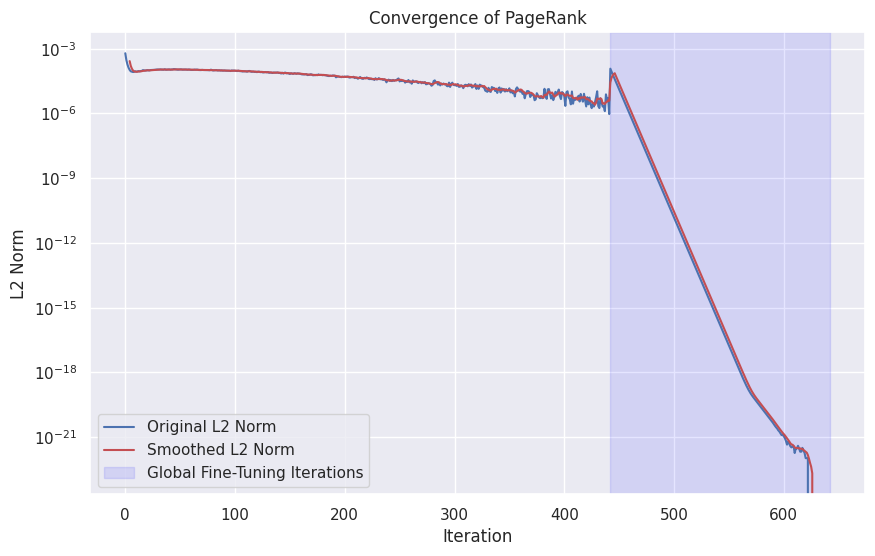

In [5]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

adata =  scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise, backed='r')

if model_params['sample_data_knn'] != False:
    if model_params['straify_sampling'] == True:
        print('Empirical bayes sampling option selected')
        adata_samp, indices, weights = scent.empirical_bayes_balanced_stratified_KNN_sampling(adata, **model_params)
        scent.plot_sampling_metrics(adata,adata_samp, **model_params)
        adata_samp = adata_samp.to_memory()
    else:
        print('Attention-based non-straified sampling selected')
        adata_samp,sample_probs, weights = scent.Attention_based_KNN_sampling(adata, **model_params)
        adata_samp = adata_samp.to_memory()
print('adata_loaded')

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

capture_1


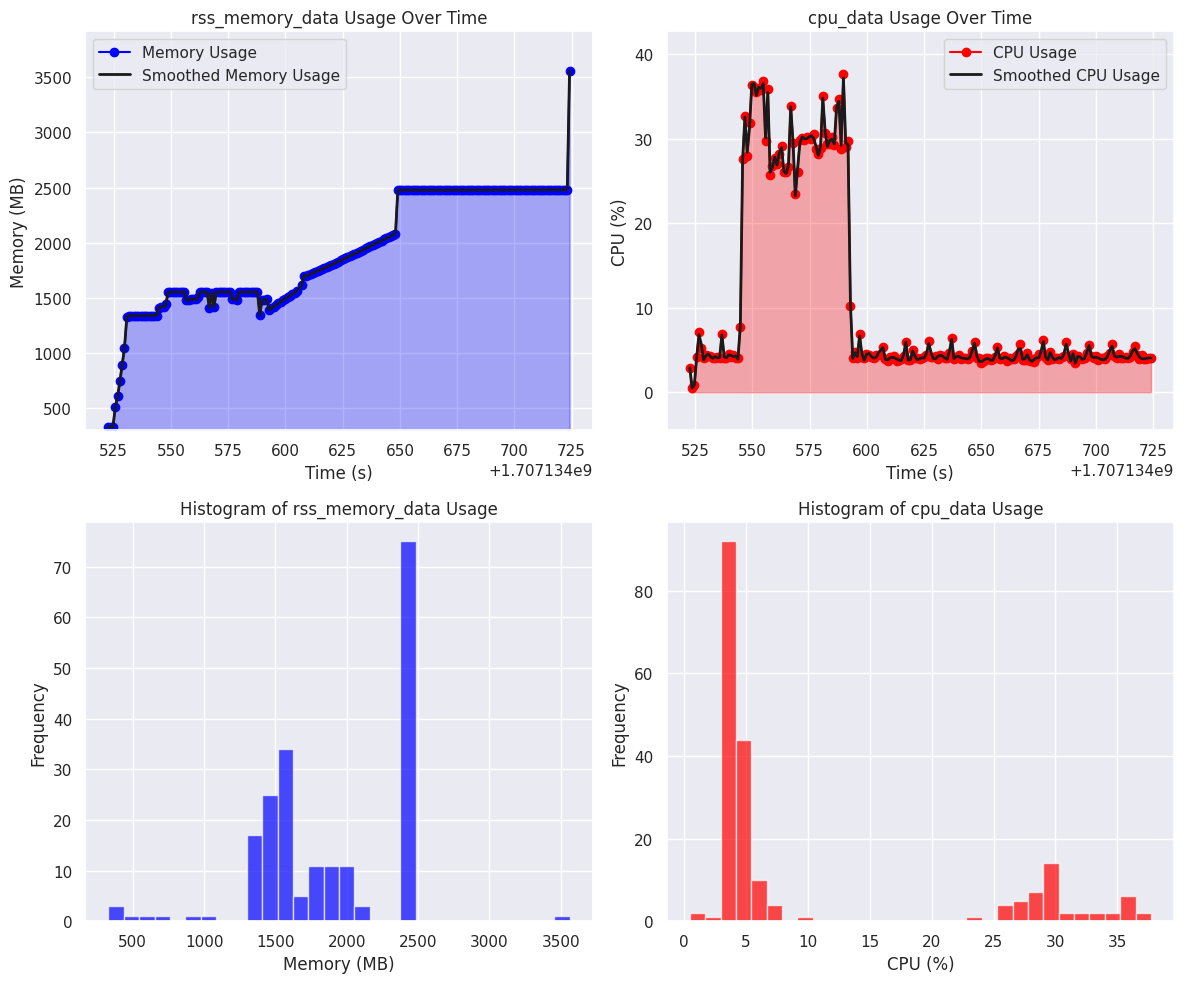

In [6]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """
# Stop the monitoring
monitor.stop_monitoring()
plot_resources(monitor)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
captured_output.show()

### Removed "feat_use" from model params to demonstrate that non-stratified sampler is independent of labels
- added back in below to show conservation of cell-states

capture_1


... storing 'anno_lvl_2_final_clean' as categorical
... storing 'anno_lvl_2_final_clean' as categorical


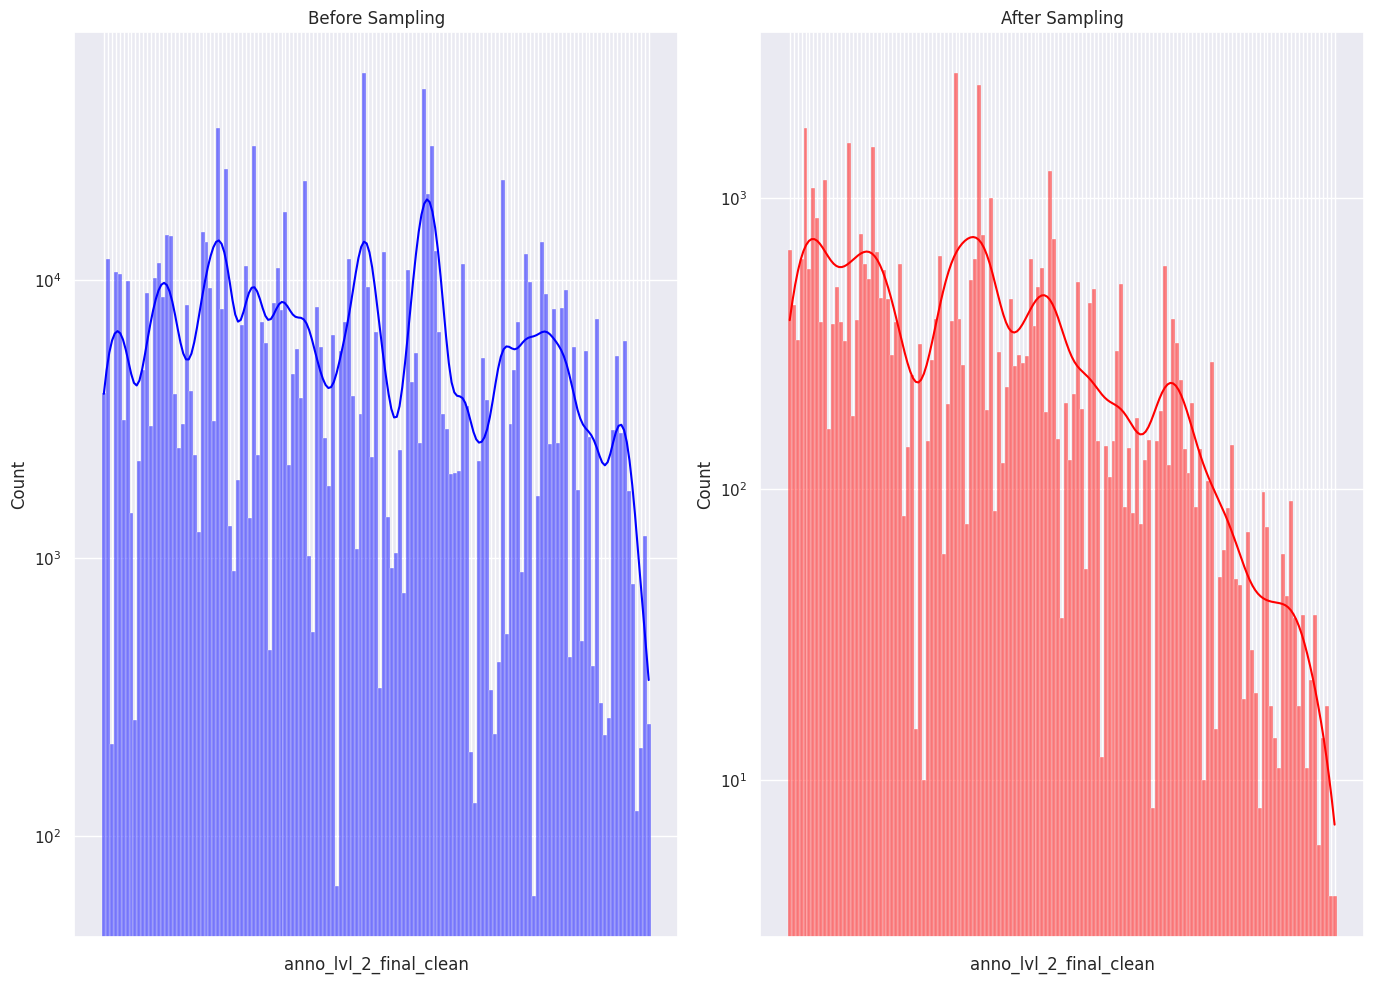

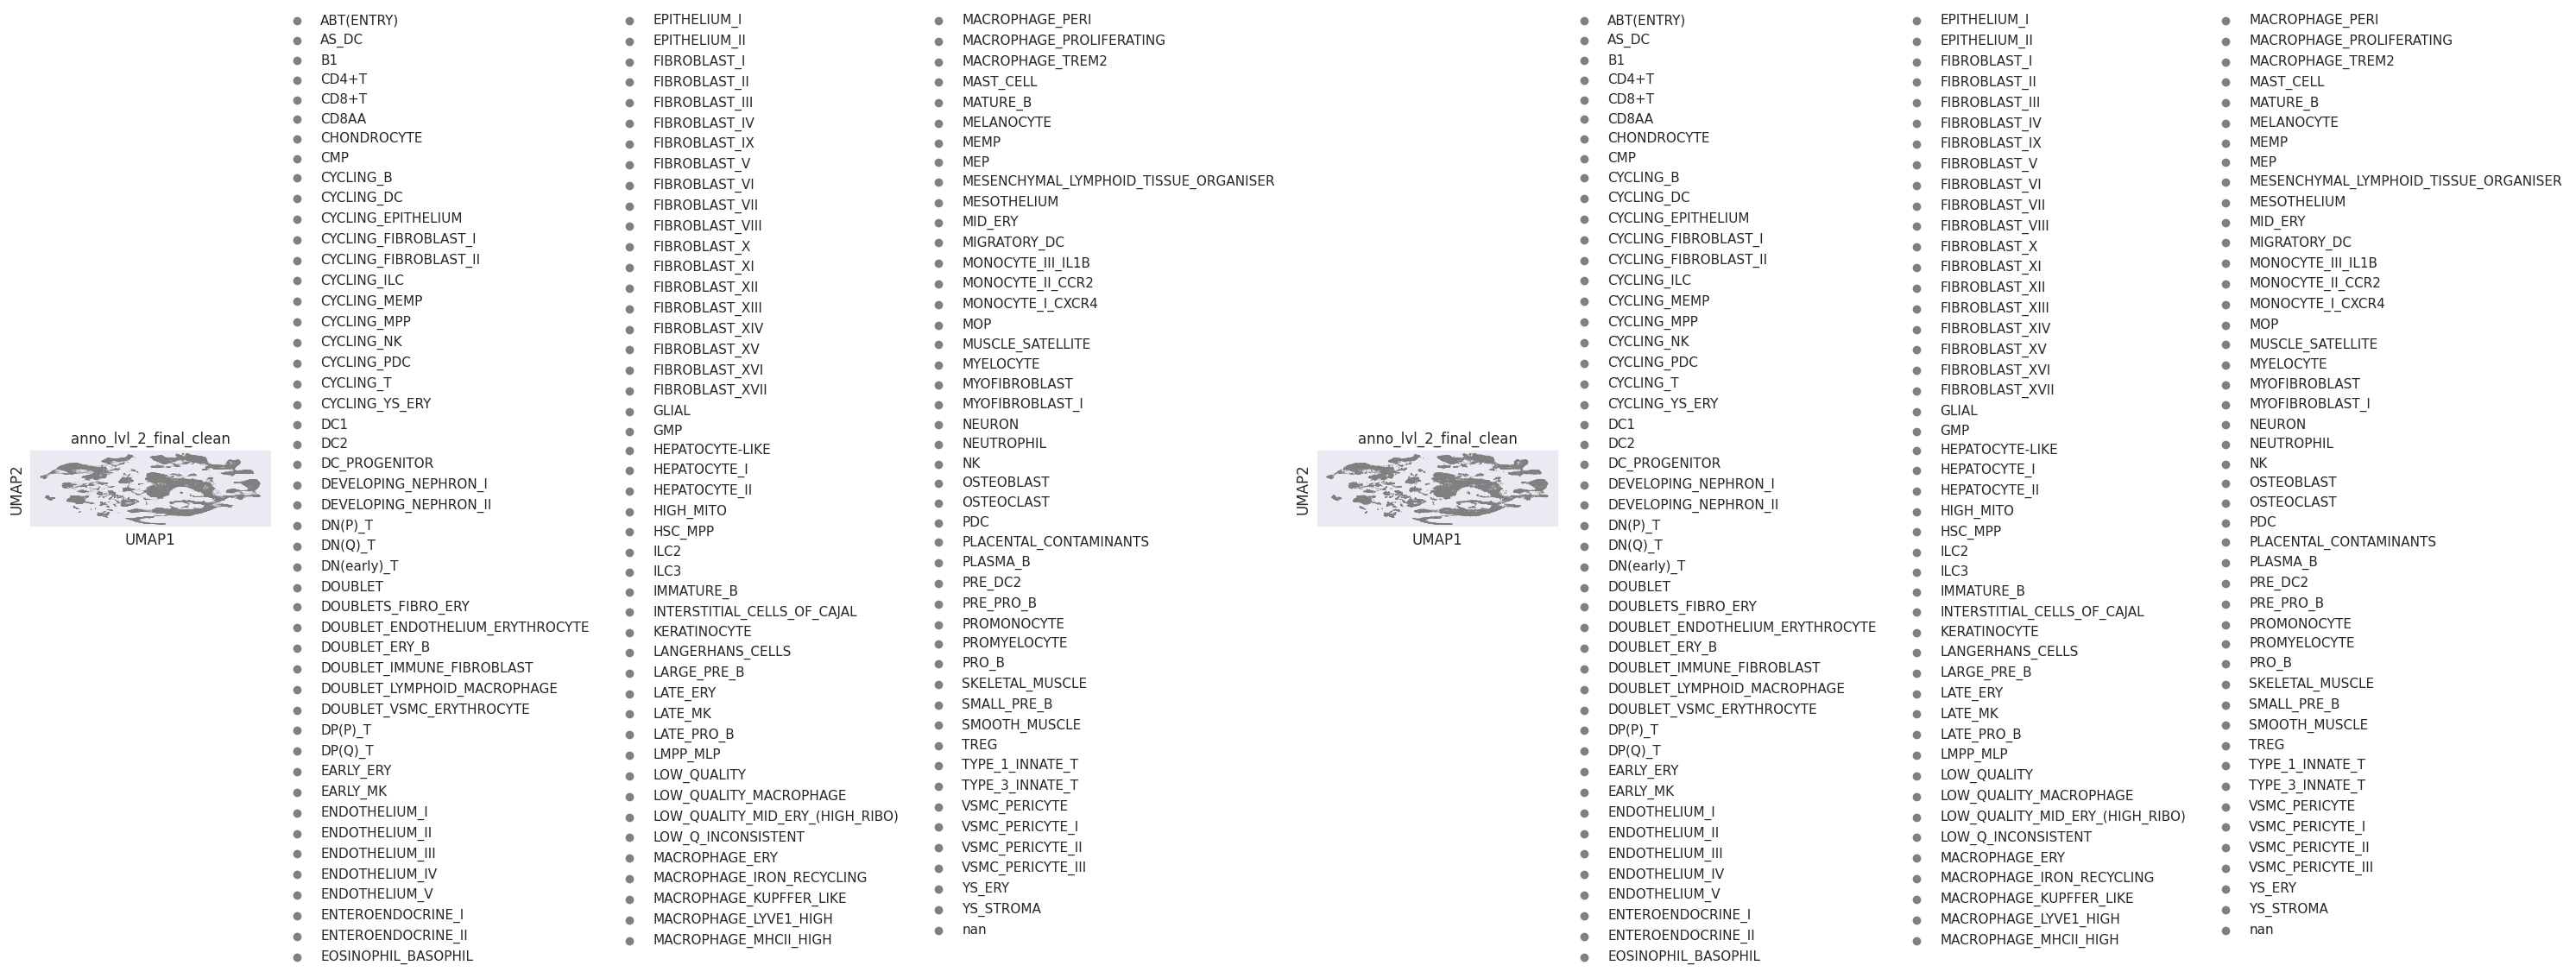

In [7]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

#model_params['feat_use']= 'LVL3'
adata.obs[model_params['feat_use']] = adata.obs[model_params['feat_use']].astype(str)
adata_samp.obs[model_params['feat_use']] = adata_samp.obs[model_params['feat_use']].astype(str)
scent.plot_sampling_metrics(adata,adata_samp, **model_params)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(30,7))

# Plot the UMAPs on these axes
sc.pl.umap(adata, color=model_params['feat_use'], ax=axs[0], show=False)
sc.pl.umap(adata_samp, color=model_params['feat_use'], ax=axs[1], show=False)
# Display the plots
plt.tight_layout()
plt.show()

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

# Show the sampling distribution

capture_2


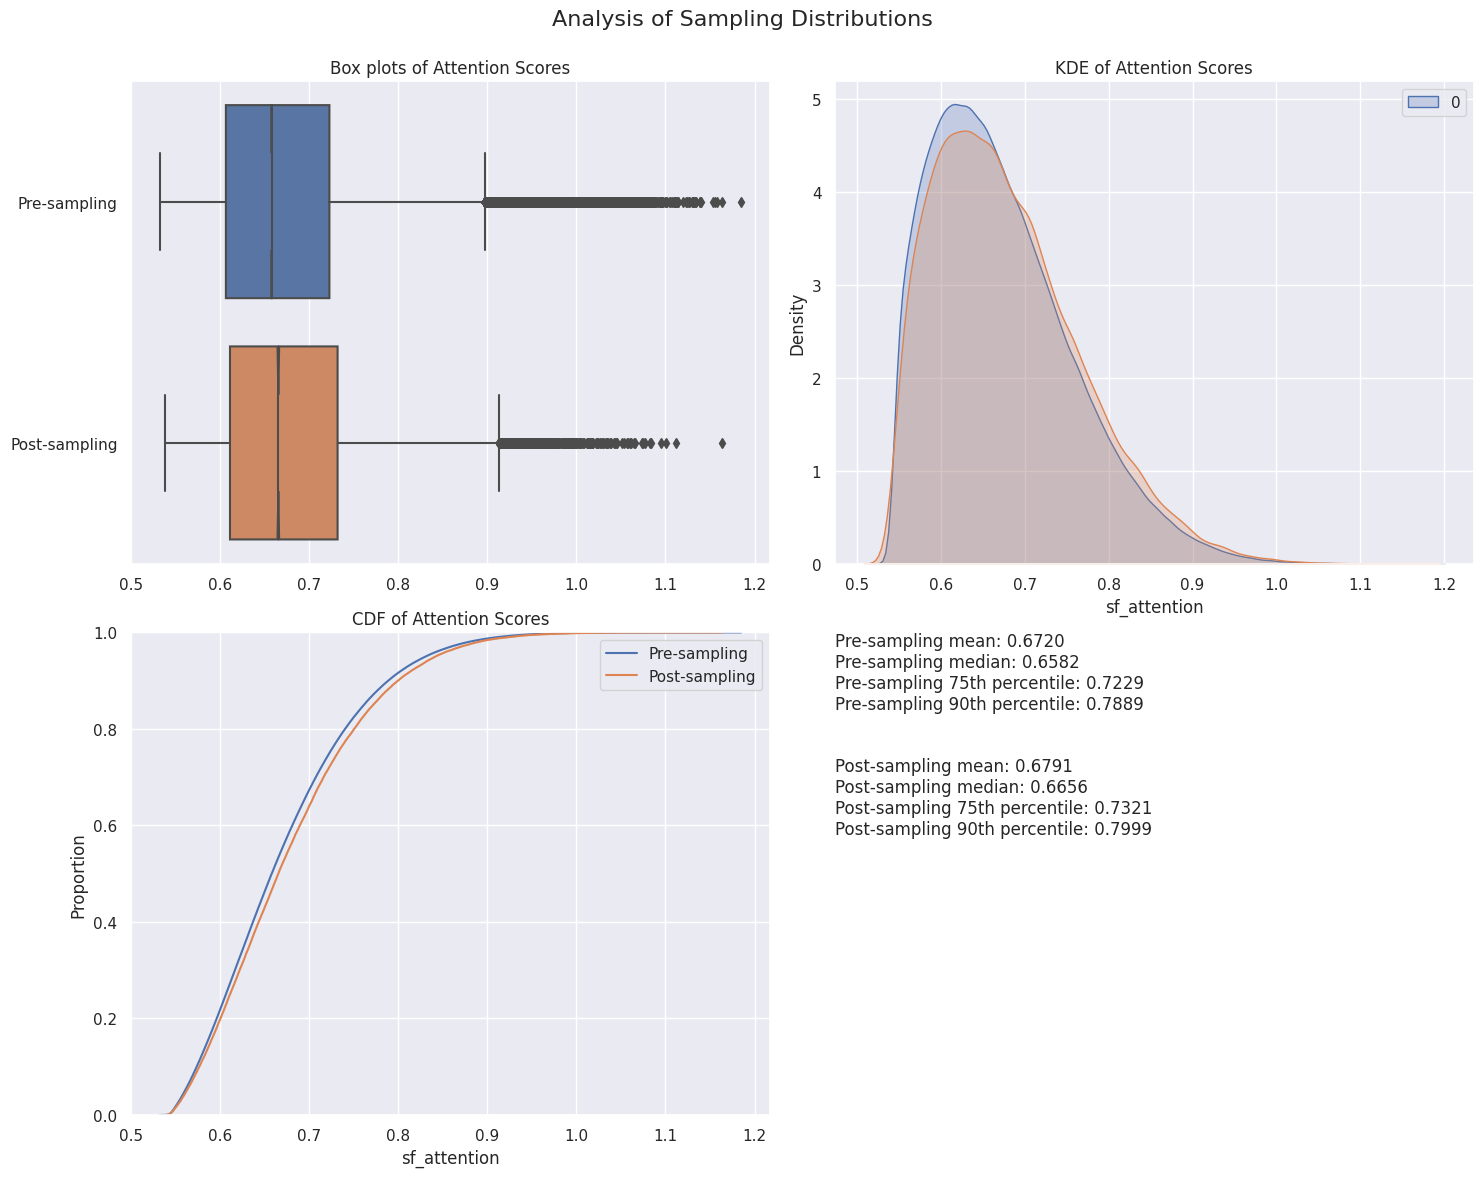

In [8]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """
# Extract attention scores
pre_sample_scores = weights['all_weights']
post_sample_scores = adata_samp.obs['sf_attention']
scent.analyze_sampling_distribution(pre_sample_scores, post_sample_scores)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

# Optionally expand neighborhoods to explicitly cover all nodes in graph
- This application adopts a dynamic expansion strategy to recover rare transitional relationships available in the graph
- It applies an adaptive gaussian kernel function to prune the resultant dynamically expanded graph
- This module can be computationally expensive during reconstruction of the graph

#### Simple measure if all cells are connected to minimum 1 pseudocell

- Set anchor states as selected pseudocells
- All cells must be connected to a minimum of alpha pseudostates
- Neighborhood hop performed dynamically


### Workflow:
- Compute naive sampling with attention scores
- Iteratively expand neighborhod until they meet a minimum alpha
- dynamically prune the updated graphs with an adaptive gaussian kernel
- Recompute updated pagerank chunk
- Re-sample and test for connectivity.

## Author module notes:

### A0.2.1 -- Test code for dynamic hop updates
- incoperate parallelisation
- include batch processing for matrix reconstruction
- include efficient matrix multiplication operations

### V0.2.1 Adapative Gaussian kernel pruning
- Post dynamic expansion, we design an adaptive gaussian kernel pruning strategy
- Compute the Gaussian Kernel: For each connection in the matrix, calculate the Gaussian kernel value. The Gaussian kernel typically depends on the distance between nodes and a scaling parameter (like variance).

- Apply the Kernel to the Connectivity Matrix: Multiply the connectivity matrix by the Gaussian kernel values. This operation will adjust the weights of the connections based on the kernel.

- Preserve Connections to Anchor Nodes: Ensure that connections to anchor nodes are not removed or diminished. This might involve setting the kernel value to 1 (or maximum) for these connections.

- Prune Low-Weight Connections: After applying the kernel, prune connections that fall below a certain threshold, which can help in removing weak connections.

###  V0.2.1 Adaptive Pruning notes
- The pruning process is adaptive in the sense that it adjusts the connections in the matrix based on the context (i.e., the distance or similarity between points) rather than applying a uniform threshold. This adaptiveness is primarily achieved through the Gaussian kernel, which gives more weight to closer or more similar nodes and less to those farther away or less similar.

- Gaussian Kernel: By applying the Gaussian kernel, you scale the weights of the connections based on their distance/similarity. Closer or more similar nodes get higher weights.

- Preserving Anchor Nodes: By ensuring that connections to anchor nodes are not pruned, you adaptively preserve important structures in your data.

- Thresholding: By setting a threshold, you prune away connections that are below a certain level of significance. This threshold can be adaptive too, for example, it could be set relative to the average weight of connections in the matrix.

In [9]:
# Create an instance of the ResourceMonitor
monitor = scent.ResourceMonitor()
# Start monitoring
monitor.start_monitoring(interval=1)
import time
time.sleep(3)

In [10]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)
print('current memory = {}'.format(monitor.rss_memory_data[-1]))

results = scent.expand_neighborhoods_chunked(adata, adata_samp, **model_params)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)
print('current memory = {}'.format(monitor.rss_memory_data[-1]))

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

capture_3
Current Time = 12:05:58
current memory = 2820.390625
Alpha is set to 0, this means that no expansion towards anchor states will occur, we will default this value to 1
Epoch: 0
End of epoch 0 Unconnected node count is: 20
Epoch: 1
End of epoch 1 Unconnected node count is: 0
You are running V0.2.2 module
module to force symmetry active
Parallel update module available, proceeding
26 compute cores available, distributing 4 jobs
Applying Adaptive gaussian kernel to prune connections
Remaining unconnected node count is: 0
Current Time = 12:08:04
current memory = 7754.86328125


Processing chunks in parallel: 100%|##########| 4/4 [00:48<00:00, 12.16s/it]


capture_4


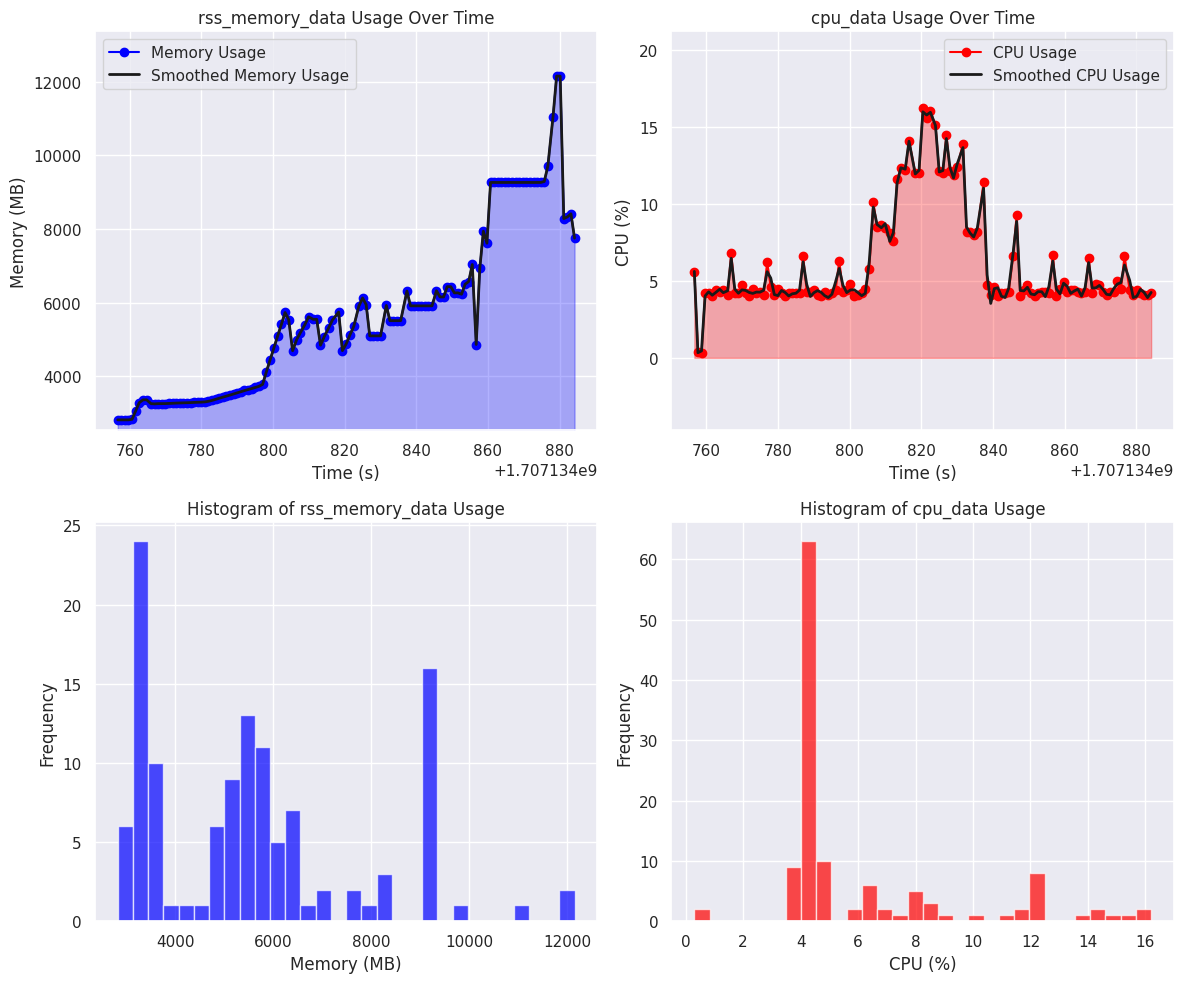

In [11]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """
# Stop the monitoring
monitor.stop_monitoring()
plot_resources(monitor)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt+=1
captured_output.show()

In [12]:
KNN_dyn =  results['main_matrix'].copy() 
(KNN_dyn[0].todense())[(KNN_dyn[0].todense()) > 0]

matrix([[0.8165718 , 1.        , 0.22664703, 0.11324817, 0.692972  ,
         0.13043863, 0.1199711 , 0.21954538, 0.19684318, 0.80433124,
         0.15207648, 0.44692656, 0.38618216, 0.23272265, 1.5116158 ,
         0.24550773, 0.29886308, 0.12867932, 0.33343604, 0.11728778,
         0.37172163, 0.19754152, 0.10253782, 0.12444592, 0.22559543,
         0.12215994, 2.1361454 , 1.1316909 , 0.95313144, 0.29870522,
         0.22908156, 0.10496425, 0.10946548, 0.17658941, 0.12753731,
         0.66274506]], dtype=float32)

In [13]:
# Create an instance of the ResourceMonitor
monitor = scent.ResourceMonitor()
# Start monitoring
monitor.start_monitoring(interval=1)
import time
time.sleep(3)

capture_5
Current Time = 12:08:09
Attention-based non-straified sampling selected
Non-stratified sampling based on attention weights chosen
Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank
Pre-initialised vector provided
Converged at iteration 430
Proceeding on to perform fine-tuning across full-batch
You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement
proceeding to 2 stage sampling using attention scores as priors
Sampling complete!
Current Time = 12:12:12


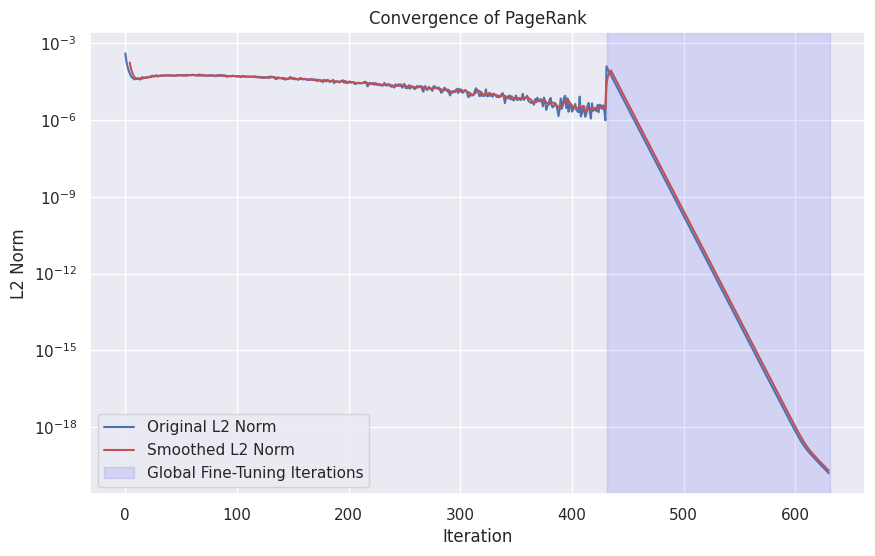

In [14]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

update_mat = results['main_matrix']
model_params['init_vect'] = weights['v']
# Set the updated neighborhood expansion as main KNN matrix
adata.obsp[adata.uns[model_params['knn_key']]['connectivities_key']] = update_mat
print('Attention-based non-straified sampling selected')
adata_samp,sample_probs, weights = scent.Attention_based_KNN_sampling(adata, **model_params)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)


""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

capture_6


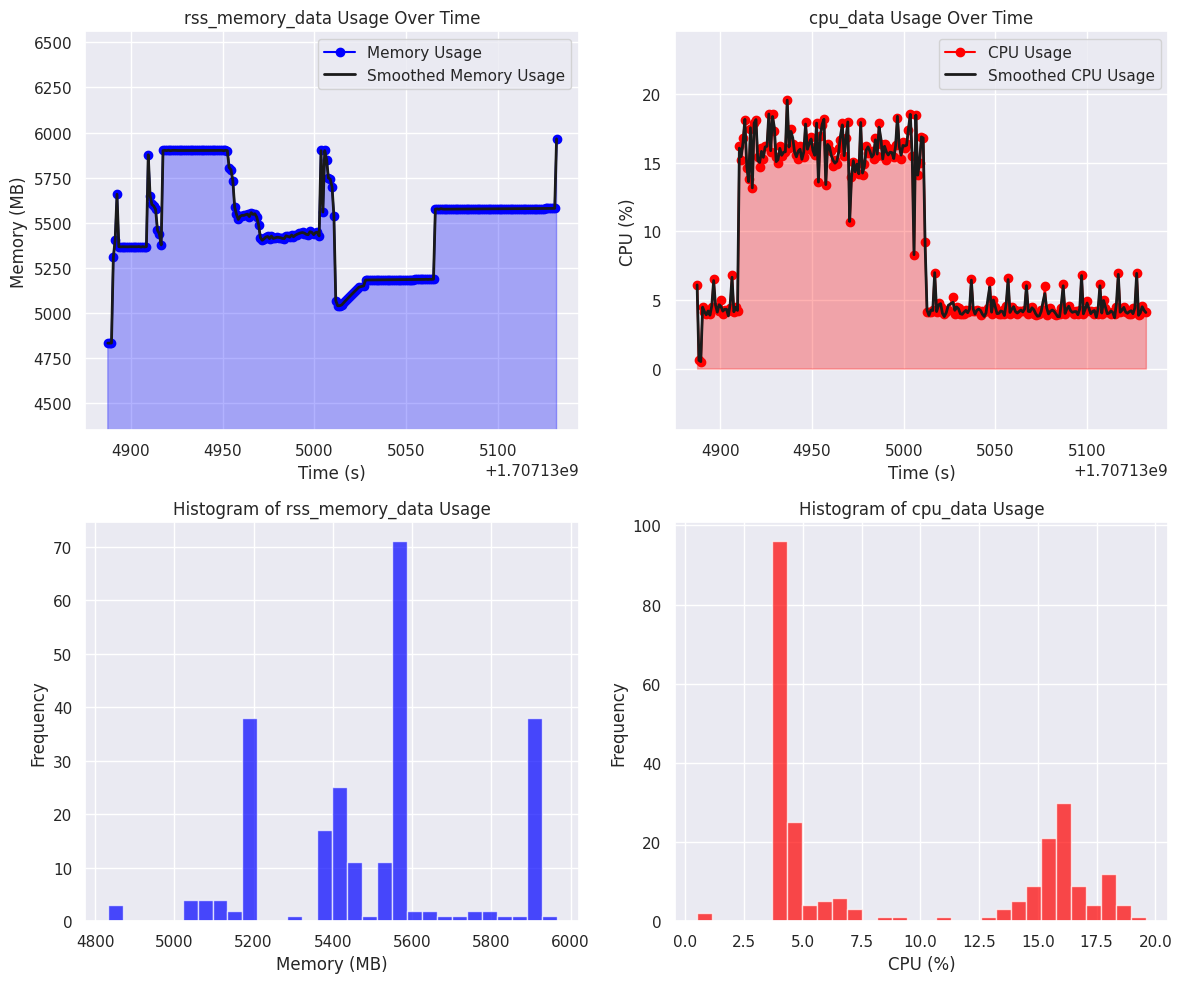

In [15]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

# Stop the monitoring
monitor.stop_monitoring()
plot_resources(monitor)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

capture_7


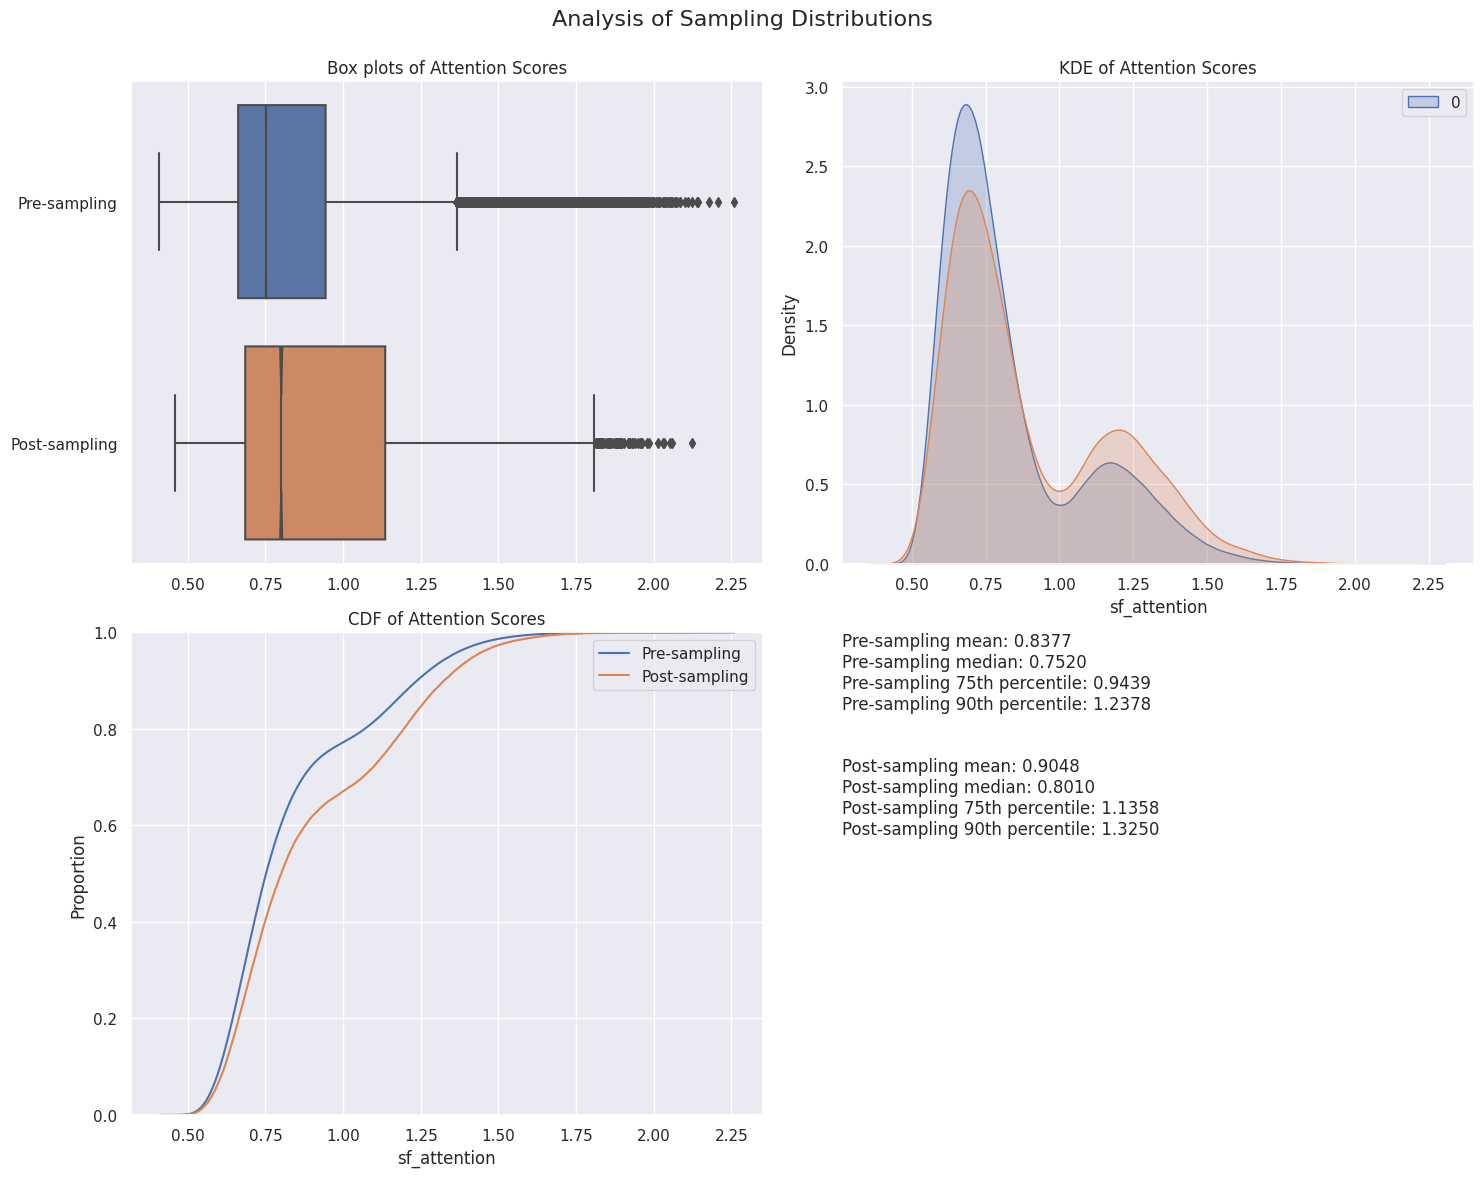

In [16]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f'--no-stderr --no-stdout {cap_key}', """
# Extract attention scores
pre_sample_scores = weights['all_weights']
post_sample_scores = adata_samp.obs['sf_attention']
scent.analyze_sampling_distribution(pre_sample_scores, post_sample_scores)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

capture_8


... storing 'anno_lvl_2_final_clean' as categorical
... storing 'anno_lvl_2_final_clean' as categorical


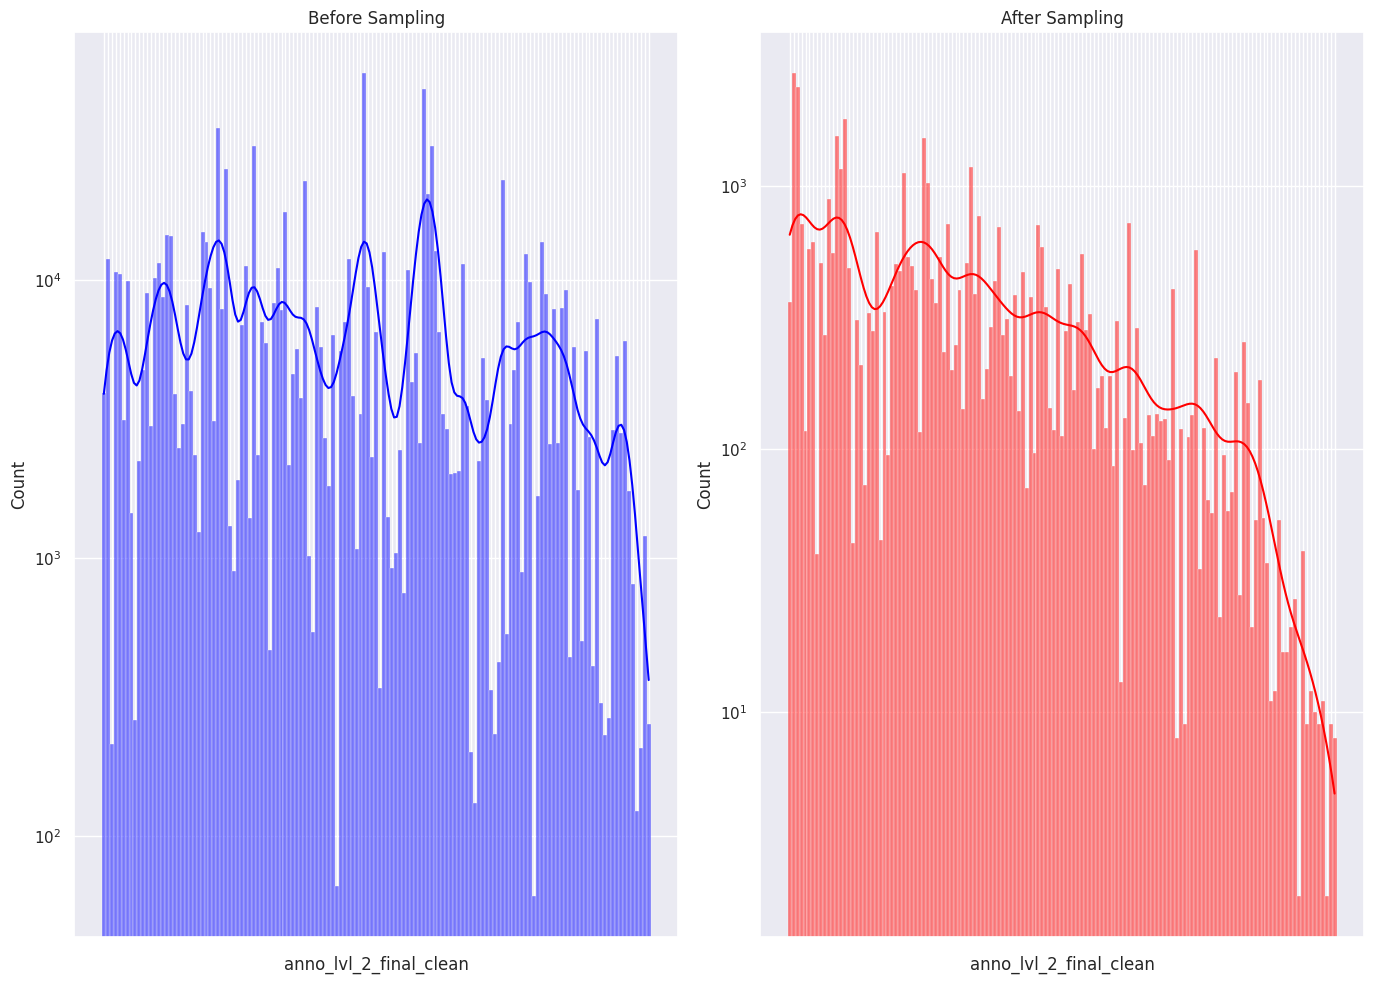

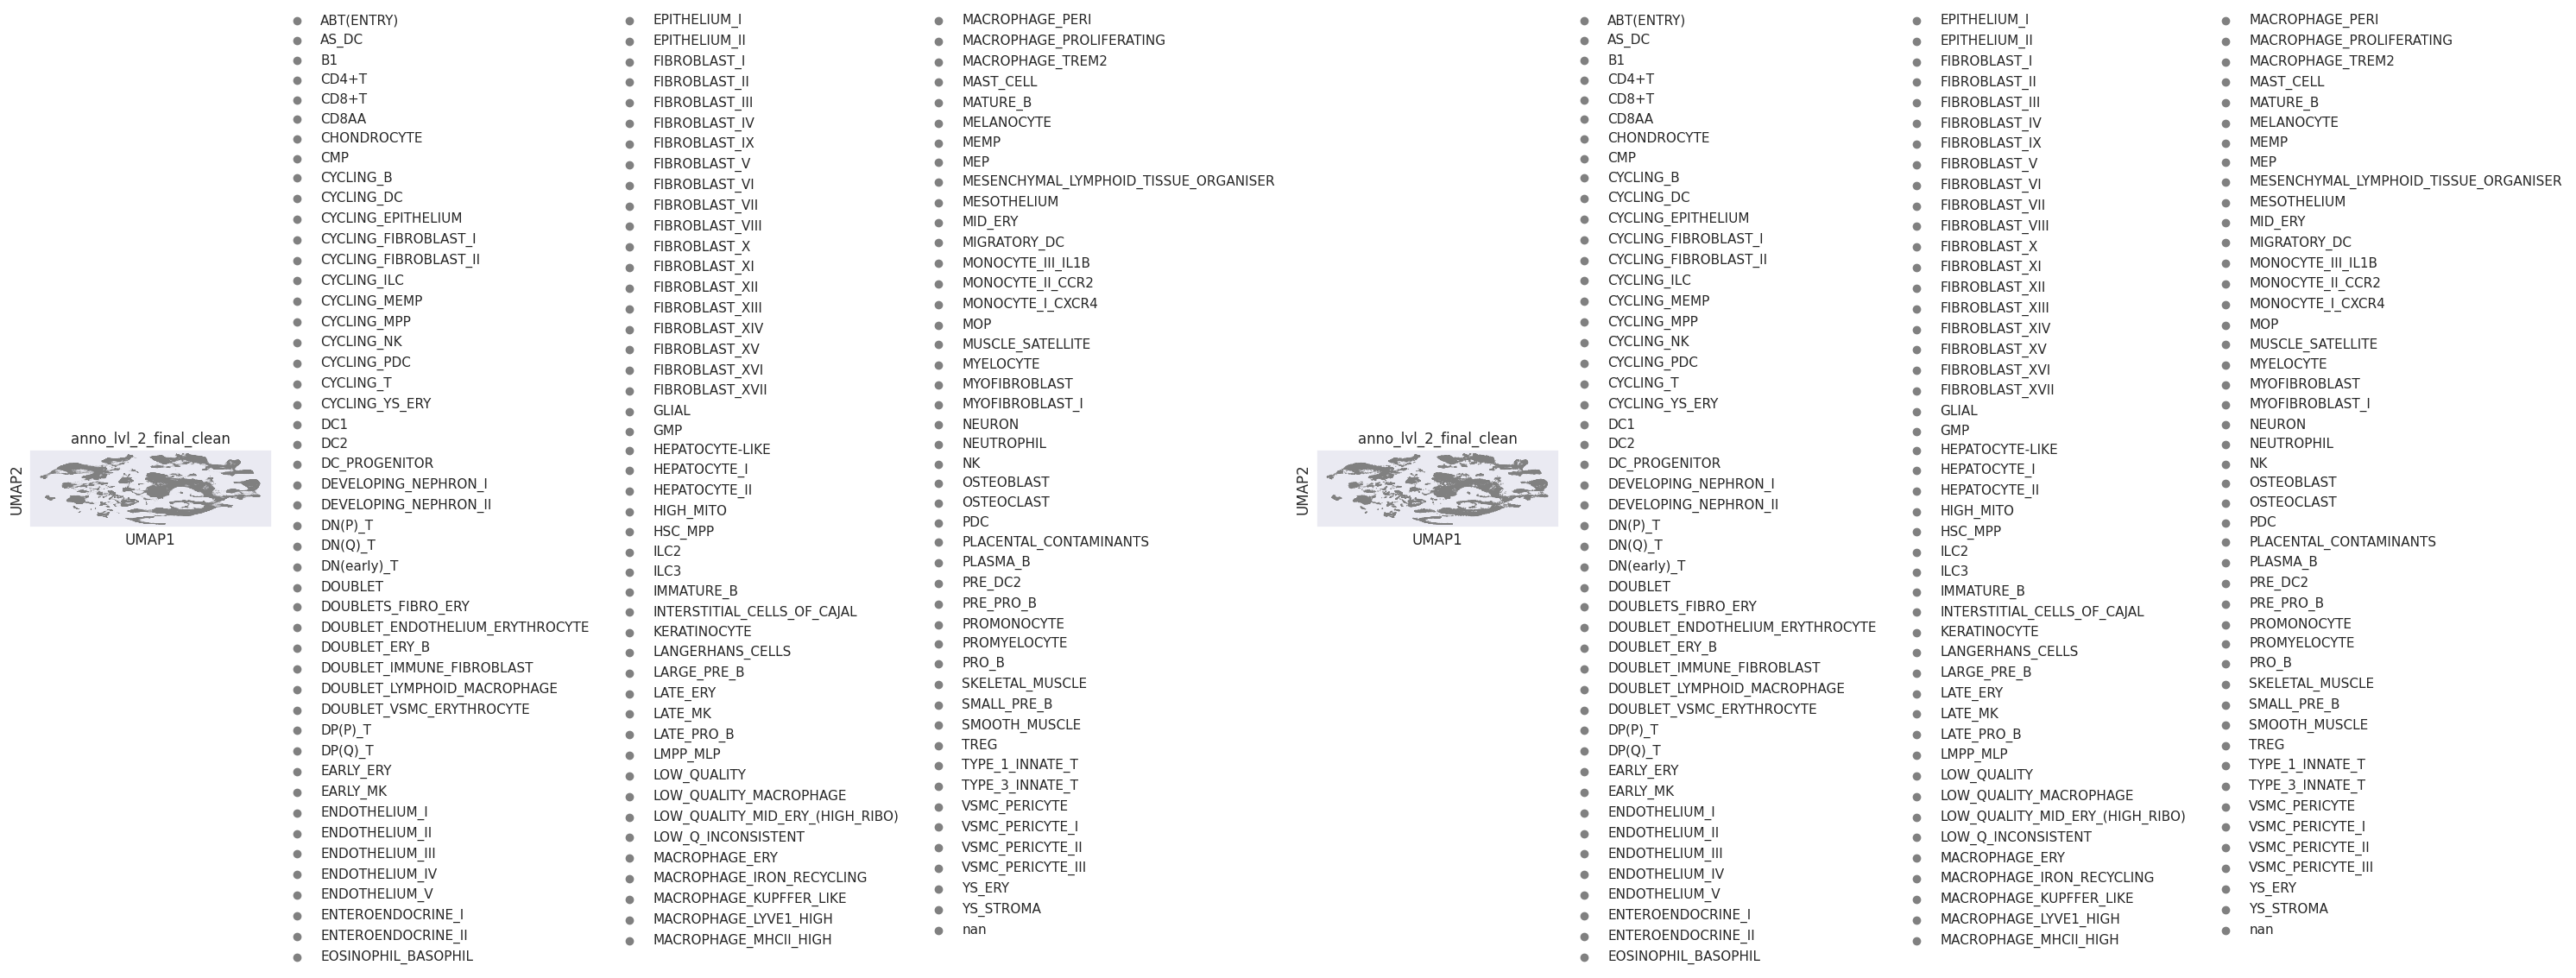

In [17]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

#model_params['feat_use']= 'LVL3'
adata.obs[model_params['feat_use']] = adata.obs[model_params['feat_use']].astype(str)
adata_samp.obs[model_params['feat_use']] = adata_samp.obs[model_params['feat_use']].astype(str)
scent.plot_sampling_metrics(adata,adata_samp, **model_params)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(30,7))

# Plot the UMAPs on these axes
sc.pl.umap(adata, color=model_params['feat_use'], ax=axs[0], show=False)
sc.pl.umap(adata_samp, color=model_params['feat_use'], ax=axs[1], show=False)
# Display the plots
plt.tight_layout()
plt.show()

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

In [18]:
# Create an instance of the ResourceMonitor
monitor = scent.ResourceMonitor()
# Start monitoring
monitor.start_monitoring(interval=1)
import time
time.sleep(3)

In [19]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

# Create pseudocells from the main data
import anndata
from tqdm import tqdm
import gc

#adata_samp = adata[adata.obs.index.isin(adata_samp.obs.index)].to_memory()
connectivity_matrix = adata.obsp[adata.uns[model_params['knn_key']]['connectivities_key']]

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

pseudobulk_adata = scent.aggregate_data(adata, adata_samp, connectivity_matrix, method='local',chunk_size = 10000) # method = "sum" aggregate by sum for equal weighting for all neighbors

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

capture_9
Current Time = 12:12:49
Data is too large to process in a single view, processing in chunks 
Current Time = 12:27:24


Processing chunks: 100%|##########| 5/5 [14:33<00:00, 174.77s/chunk]


capture_10


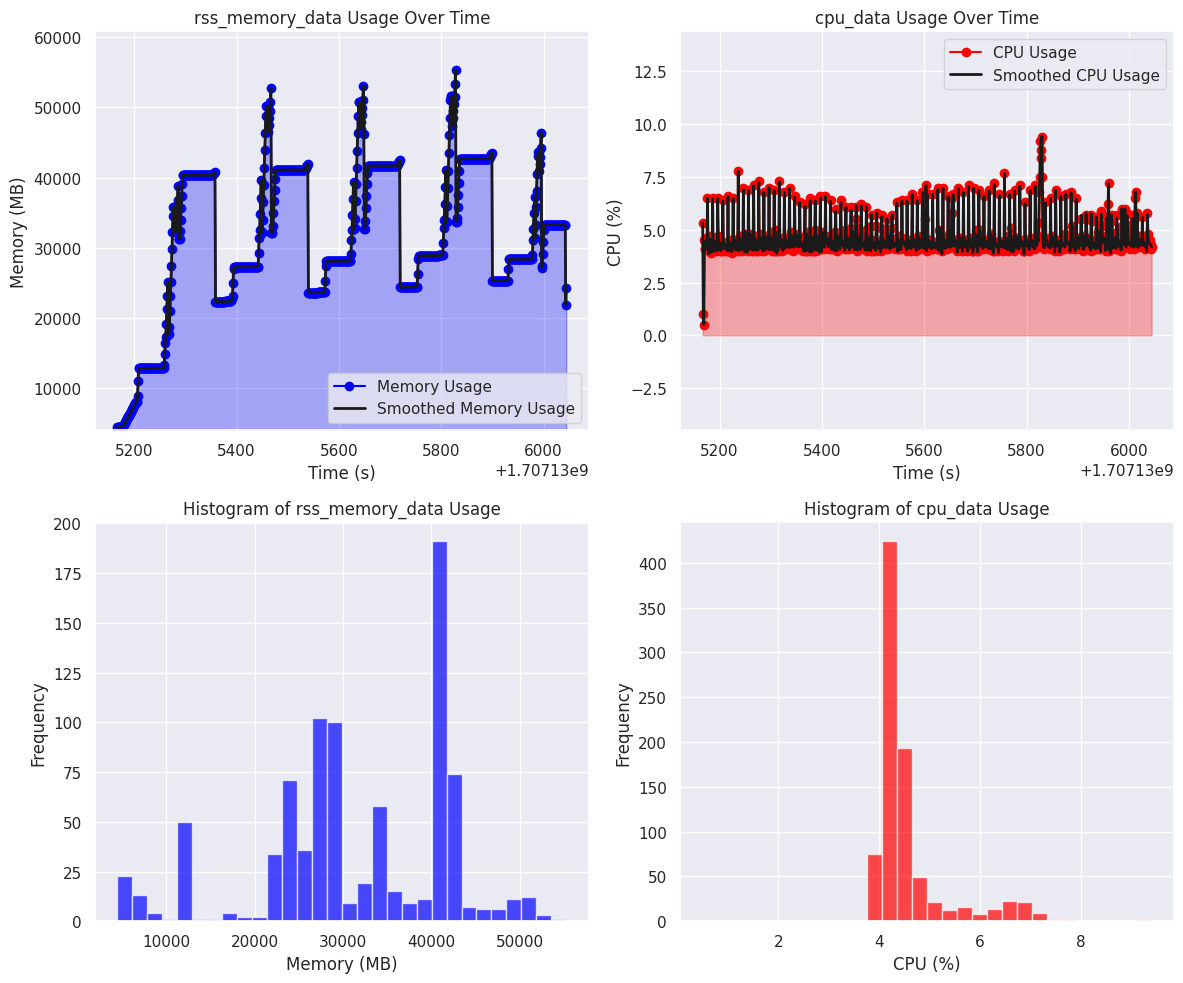

In [20]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

# Stop the monitoring
monitor.stop_monitoring()
plot_resources(monitor)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

In [21]:
# Create an instance of the ResourceMonitor
monitor = scent.ResourceMonitor()
# Start monitoring
monitor.start_monitoring(interval=1)
import time
time.sleep(3)

In [ ]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

pseudobulk_adata_tt = pseudobulk_adata.copy()
sc.pp.normalize_per_cell(pseudobulk_adata_tt, counts_per_cell_after=1e4)
sc.pp.log1p(pseudobulk_adata_tt)
print(np.max(pseudobulk_adata_tt.X))
#pseudobulk_adata.obsm = adata_samp.obsm
sc.pp.highly_variable_genes(pseudobulk_adata_tt, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(pseudobulk_adata_tt,use_highly_variable=True)
sc.pp.neighbors(pseudobulk_adata_tt, n_neighbors=20, n_pcs=30)
sc.tl.umap(pseudobulk_adata_tt)
sc.pl.umap(pseudobulk_adata_tt,color = model_params['feat_use'])
sc.pl.umap(adata,color =model_params['feat_use'])

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

capture_11


# Compared against SCVI embeddings:

In [ ]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

plt_var = 'organ'
print('newly computed umap')
sc.pl.umap(pseudobulk_adata_tt,color = plt_var,title ='Pseudocell data newly computed UMAP')

print('original umap')
pseudobulk_adata_tt.obsm['X_umap_back'] = pseudobulk_adata_tt.obsm['X_umap']
pseudobulk_adata_tt.obsm['X_umap'] = adata_samp.obsm['X_umap']
sc.pl.umap(pseudobulk_adata_tt,color = plt_var,title ='Pseudocell data original scvi UMAP')
sc.pl.umap(adata,color =plt_var, title = 'All data original scvi UMAP')

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

In [ ]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

# Stop the monitoring
monitor.stop_monitoring()
plot_resources(monitor)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

In [ ]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """


grouping = model_params['feat_use']
plot_vars = ['weights', 'probs', 'bootstrap_stratified','bootstrap_non_stratified', 'SGD_PGR_output']

obs = adata.obs[[model_params['feat_use']]].copy()
# Create a randomized sampling 
random_sampling_probabilities = scent.compute_sampling_probability(obs ,grouping, sample_fraction=0.1, n_iterations=1000)
# Add the SGD_PGR sampled data distribution
samp_obs = adata_samp.obs.copy()
samp_obs = dict(samp_obs.groupby(grouping).size()/sum(samp_obs.groupby(grouping).size()))

obs['weights'] = weights['all_weights']
obs = obs.iloc[list(sample_probs.keys())]
obs['probs'] = list(sample_probs.values())
obs = obs.groupby(grouping).mean()

# Add random sampling
for key in random_sampling_probabilities.keys():
    column_name = f'bootstrap_{key}'
    obs[column_name] = [random_sampling_probabilities[key].get(group, 0) for group in obs.index]

# Handle missing categories and add SGD_PGR sampled data
missing_categories = []
sgd_pgr_output = []

for group in obs.index:
    try:
        sgd_pgr_output.append(samp_obs[group])
    except KeyError:
        missing_categories.append(group)
        sgd_pgr_output.append(None)  # Or any default value you'd prefer, like np.nan

obs['SGD_PGR_output'] = sgd_pgr_output

if missing_categories:
    print(f"Missing categories in samp_obs: {', '.join(missing_categories)}")
else:
    print('No missing categories')

scent.plot_grouped_distributions(obs, plot_vars, grouping)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

# If we don't conduct SGD-PGR and just randomly sample then create pseudocells

In [ ]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

# Generate random indices
s_rate = 0.1
n_samples = int(adata.shape[0]*s_rate)
random_indices = list(np.random.choice(adata.shape[0], size=n_samples, replace=False))
adata_samp_rand = adata[random_indices].to_memory()
sc.pp.normalize_per_cell(adata_samp_rand, counts_per_cell_after=1e4)
sc.pp.log1p(adata_samp_rand)
print(np.max(adata_samp_rand.X))
#pseudobulk_adata.obsm = adata_samp.obsm
sc.pp.highly_variable_genes(adata_samp_rand, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(adata_samp_rand,use_highly_variable=True)
sc.pp.neighbors(adata_samp_rand, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata_samp_rand)
sc.pl.umap(adata_samp_rand,color = plt_var)
adata_samp_rand.obs.groupby([grouping]).apply(len)/sum(adata.obs.groupby([grouping]).apply(len))

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

To quantify the difference between the explained variance of PCA components for the original data and the subsample, use the Root Mean Square Error (RMSE):

$$
\text{RMSE} = \sqrt{\frac{\sum_{i=1}^{n} (x_i - y_i)^2}{n}}
$$

Here \(x_i\) and \(y_i\) are the explained variances for the \(i\)-th principal component in the original and subsampled data, respectively, and \(n\) is the number of components

In [ ]:
adata_tt = adata.to_memory()
sc.pp.normalize_per_cell(adata_tt, counts_per_cell_after=1e4)
sc.pp.log1p(adata_tt)
sc.pp.highly_variable_genes(adata_tt, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(adata_tt,use_highly_variable=True)

In [ ]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """


import matplotlib.pyplot as plt

# Step 1: Extract Explained Variance Ratios
explained_variance_adata = adata_tt.uns['pca']['variance_ratio']
explained_variance_adata_tmp = pseudobulk_adata_tt.uns['pca']['variance_ratio']

# Calculate the RMSE
n = len(explained_variance_adata)
rmse = np.sqrt(np.mean((explained_variance_adata - explained_variance_adata_tmp)**2))

fig, axes = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [4, 1]})

# Main Plot
axes[0].plot(explained_variance_adata, label='Original Data', marker='o')
axes[0].plot(explained_variance_adata_tmp, label='Subsample', marker='x')
axes[0].fill_between(range(len(explained_variance_adata)), explained_variance_adata, explained_variance_adata_tmp, 
                     where=(explained_variance_adata - explained_variance_adata_tmp) > 0, color='red', alpha=0.3, label='Significant Difference')
axes[0].fill_between(range(len(explained_variance_adata)), explained_variance_adata, explained_variance_adata_tmp, 
                     where=(explained_variance_adata - explained_variance_adata_tmp) < 0, color='blue', alpha=0.3, label='Significant Difference')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA Explained Variance Comparison_' + str(rmse))
axes[0].legend()
axes[0].set_yscale("log")

# Subplot for Differences
diff_variance = explained_variance_adata - explained_variance_adata_tmp
axes[1].plot(diff_variance, label='Difference', marker='s', linestyle=':', linewidth=2, markersize=6, color='g')
axes[1].axhline(0, color='black', linewidth=0.5)  # Zero line
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Difference')

plt.tight_layout()
plt.show()

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

In [ ]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

# Get the loadings
loadings_adata = adata_tt.varm['PCs']
loadings_adata_tmp = pseudobulk_adata_tt.varm['PCs']

# For each significantly different principal component, find the top contributing genes
significant_pcs = [1,2,3,44,45,46,47]#np.where(significant_diff)[0]
for pc in significant_pcs:
    sorted_indices = np.argsort(np.abs(loadings_adata[:, pc]))[::-1]  # Sort by absolute value, high to low
    top_genes = adata.var_names[sorted_indices[:10]]  # Top 10 genes for this PC
    print(f"Top contributing genes for PC {pc+1} in original data: {top_genes.tolist()}")
    
    sorted_indices_tmp = np.argsort(np.abs(loadings_adata_tmp[:, pc]))[::-1]  # Sort by absolute value, high to low
    top_genes_tmp = pseudobulk_adata.var_names[sorted_indices_tmp[:10]]  # Top 10 genes for this PC
    print(f"Top contributing genes for PC {pc+1} in subsampled data: {top_genes_tmp.tolist()}")
    

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

In [ ]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt

# Initialize an empty list to store the similarity scores for each PC
similarity_scores = []

# For each of the top 40 PCs
for pc in range(40):
    # Get the top 100 genes based on loadings for both adata and adata_tmp
    top_genes_adata = np.argsort(np.abs(loadings_adata[:, pc]))[-200:]
    top_genes_adata_tmp = np.argsort(np.abs(loadings_adata_tmp[:, pc]))[-200:]
    
    # Calculate the Jaccard similarity between the two sets
    intersection = len(set(top_genes_adata) & set(top_genes_adata_tmp))
    union = len(set(top_genes_adata) | set(top_genes_adata_tmp))
    jaccard_similarity = intersection / union
    
    # Append the similarity score to the list
    similarity_scores.append(jaccard_similarity)

# Calculate the mean similarity
mean_similarity = np.mean(similarity_scores)

# Plotting the similarity scores
plt.figure(figsize=(10, 6))
plt.bar(range(1, 41), similarity_scores, color='blue')
plt.axhline(y=mean_similarity, color='r', linestyle='--', label=f'Mean Similarity = {mean_similarity:.2f}')
plt.xlabel('Principal Component')
plt.ylabel('Jaccard Similarity')
plt.title('Gene Set Similarity Across PCs')
plt.legend()
plt.show()


""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

In [ ]:
sc.tl.rank_genes_groups(adata_tt, groupby= model_params['feat_use'],method='wilcoxon', use_raw=False)
sc.tl.rank_genes_groups(pseudobulk_adata_tt, groupby= model_params['feat_use'],corr_methodmethod='wilcoxon', use_raw=False)

In [ ]:
def get_top_genes(adata, group, n_genes=100):
    """Extract top genes for a specific group from the differential expression results."""
    genes = adata.uns['rank_genes_groups']['names'][group]
    return genes[:n_genes]

def jaccard_index(list1, list2):
    """Compute Jaccard index between two lists."""
    intersection = len(set(list1).intersection(list2))
    union = len(set(list1).union(list2))
    return intersection / union

cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

# Get the unique classes in the LVL3 grouping variable
groups = adata.obs[model_params['feat_use']].cat.categories

# Compute Jaccard indices
jaccard_indices = {}
for group in groups:
    genes_adata = get_top_genes(adata_tt, group)
    genes_pseudobulk = get_top_genes(pseudobulk_adata_tt, group)
    jaccard_indices[group] = jaccard_index(genes_adata, genes_pseudobulk)

# Plot
plt.bar(jaccard_indices.keys(), jaccard_indices.values())
plt.ylabel('Jaccard Index')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

In [ ]:
pseudobulk_adata.write('/nfs/team205/ig7/resources/github/pseudo_pan_fetal_test.h5ad')